In [3]:
import numpy as np
%matplotlib inline

import matplotlib.pyplot as plt
from tqdm import tqdm, trange

import torch
import torch.nn as nn
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
from torch.utils.data import DataLoader

from torchvision.transforms import ToTensor
from torchvision import datasets
from collections import Counter

from classic_vit_multiscale_overlapp import MultiscaleViT
from her2_dataset import HER2Dataset
from patch_embedding import PatchEmbedding

transform = ToTensor()

torch.manual_seed(0)

IMAGE_WIDTH = 299
IMAGE_HEIGHT = 299
IMAGE_CHANNELS = 3
N_PATCHES = 13

MAX_CHECKPOINTS = 3

assert IMAGE_WIDTH%N_PATCHES==0

PATCH_WIDTH = IMAGE_WIDTH//N_PATCHES
PATCH_HEIGHT = IMAGE_HEIGHT//N_PATCHES


DATASET_PATH='../datasets/HER2_gastric_5classes'
# 20% of data goes to test
TEST_SPLIT = 0.2
BATCH_SIZE = 16

N_EPOCHS = 50
LR = 0.00005


/home/newt/miniconda3/envs/ds/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:

dataset = HER2Dataset(DATASET_PATH, transform=ToTensor())
train_dataset, test_dataset = dataset.genSplits(TEST_SPLIT)
train_loader, test_loader = dataset.getDataLoaders(BATCH_SIZE)

print(f"Dataset split:\nTrain: {len(train_dataset)}\nTest: {len(test_dataset)}")



Dataset split:
Train: 1627
Test: 406


Text(0.5, 1.0, 'Test Split')

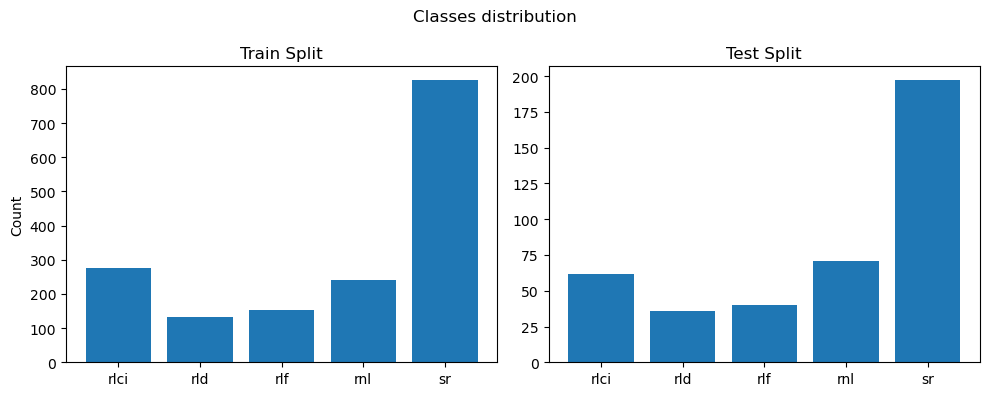

In [5]:
train_count, test_count = dataset.getSampleCountByClass()

fig, ax = plt.subplots(1, 2, tight_layout=True, figsize=(10,4))
fig.suptitle("Classes distribution")
ax[0].set_ylabel("Count")
ax[0].bar(list(zip(*train_count))[0], list(zip(*train_count))[1], tick_label=list(zip(*train_count))[2])
ax[0].set_title("Train Split")
ax[1].bar(list(zip(*test_count))[0], list(zip(*test_count))[1], tick_label=list(zip(*test_count))[2])
ax[1].set_title("Test Split")

torch.Size([16, 3, 299, 299])


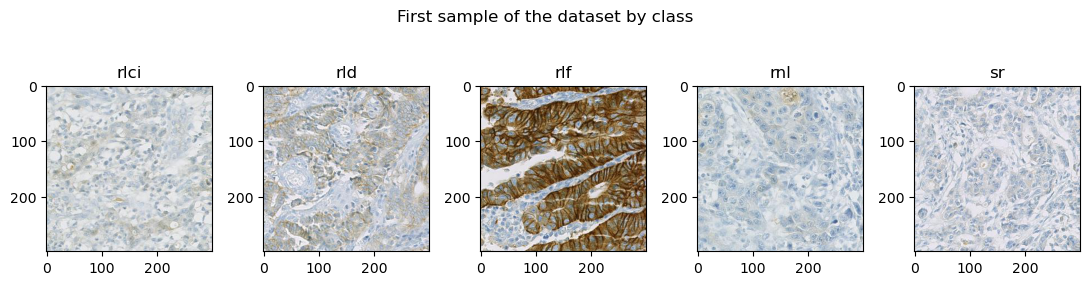

In [4]:

data_iter = iter(train_loader)
images, labels = next(data_iter)
class_first_sample = list(map(lambda x: np.where(x == np.array(labels))[0][0], dataset.class_to_idx.values()))


print(images.shape)

fig, axes = plt.subplots(tight_layout=True, ncols=len(class_first_sample), figsize=(11,3))
fig.suptitle("First sample of the dataset by class")

for ii in range(len(class_first_sample)):
    ax = axes[ii]
#     helper.imshow(images[ii], ax=ax, normalize=False)
    ax.set_title(dataset.classes[labels[class_first_sample[ii]]])
    ax.imshow(torch.transpose(images[class_first_sample[ii]], 0, 2))

In [5]:
from patch_embedding import ImagePatcher


patcher = ImagePatcher(in_channels=IMAGE_CHANNELS, patch_size=IMAGE_WIDTH//N_PATCHES, img_size=IMAGE_HEIGHT)
gridSpec = dict(top = 1, bottom = 0, right = 1, left = 0, hspace = 0., wspace = 0.)
data_iter = iter(train_loader)
images, labels = next(data_iter)
patches = patcher.toPatchesTensor(images[1].unsqueeze(0))
print(patches.shape)
#patches = patches.reshape((1, N_PATCHES,N_PATCHES,23,23,3))

# axes.vlines(range(0,IMAGE_WIDTH,PATCH_WIDTH), 0, IMAGE_HEIGHT)
# axes.hlines(range(0,IMAGE_HEIGHT,PATCH_HEIGHT), 0, IMAGE_WIDTH)

torch.Size([1, 13, 13, 3, 23, 23])


/home/newt/miniconda3/envs/ds/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


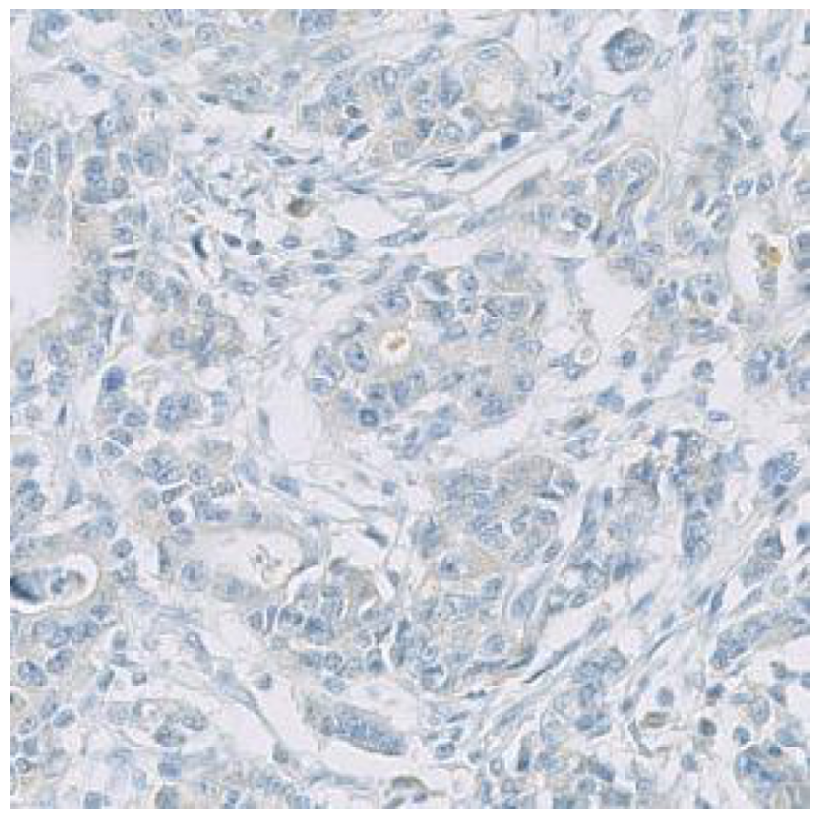

In [6]:
fig, axes = plt.subplots(N_PATCHES, N_PATCHES ,tight_layout=True, figsize=(8,8), sharex=True, sharey=True, gridspec_kw=gridSpec)
for i in range((N_PATCHES)):
    for j in range((N_PATCHES)):
        axes[i,j].axis('off')
        axes[i,j].set_aspect('equal')
        axes[i,j].imshow(torch.permute(patches[0, i, j], (1,2,0)), interpolation=None)


torch.Size([3, 299, 299])


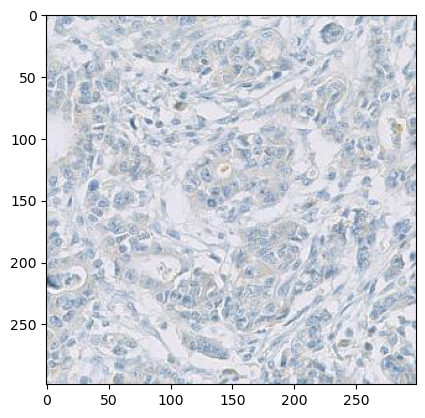

In [7]:
plt.imshow(torch.permute(images[1], (1, 2, 0)))
print(images[1].shape)

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("Using device: ", device, f"({torch.cuda.get_device_name(device)})" if torch.cuda.is_available() else "")

print(f"ROI divided into regions of {IMAGE_WIDTH}x{IMAGE_HEIGHT}x{IMAGE_CHANNELS}\nUsing {N_PATCHES}x{N_PATCHES} patches of {PATCH_WIDTH}x{PATCH_HEIGHT}x{IMAGE_CHANNELS}")
model = MultiscaleViT(
        in_channels= IMAGE_CHANNELS, 
        out_channels=24,
        img_size=IMAGE_WIDTH,
        patch_size=IMAGE_WIDTH//N_PATCHES, 
        emb_size=512,
        num_heads=32,
        depth=4,
        n_classes=len(dataset.classes), 
        dropout=0.2,
        forward_expansion=2,
        ).to(device)


# from vit_pytorch import ViT

# model = ViT(
#     image_size = IMAGE_WIDTH,
#     channels=IMAGE_CHANNELS,
#     patch_size = N_PATCHES,
#     num_classes = 5,
#     dim = 1024,
#     depth = 6,
#     heads = 16,
#     mlp_dim = 2048,
#     dropout = 0.1,
#     emb_dropout = 0.1
# ).to(device)

pytorch_total_params = sum(p.numel() for p in model.parameters())
print(pytorch_total_params)

param_size = 0
for param in model.parameters():
    param_size += param.nelement() * param.element_size()
buffer_size = 0
for buffer in model.buffers():
    buffer_size += buffer.nelement() * buffer.element_size()

size_all_mb = (param_size + buffer_size) / 1024**2
print('model size: {:.2f}MB'.format(size_all_mb))


Using device:  cuda (NVIDIA GeForce RTX 3080)
ROI divided into regions of 299x299x3
Using 13x13 patches of 23x23x3
10223781
model size: 39.00MB


In [7]:
# Training loop
MODEL_PATH= "models/bestMultiscale.pth"
optimizer = Adam(model.parameters(), lr=LR)
criterion = CrossEntropyLoss()
bestLoss = 999999;
for epoch in trange(N_EPOCHS, desc="Training"):
    train_loss = 0.0
    for batch in tqdm(train_loader, desc=f"Epoch {epoch + 1} in training", leave=False):
        x, y = batch
        x, y = x.to(device), y.to(device)
        y_hat = model(x)
        loss = criterion(y_hat, y)

        train_loss += loss.detach().cpu().item() / len(train_loader)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch + 1}/{N_EPOCHS} loss: {train_loss:.2f}")

# Test loop
    with torch.no_grad():
        correct, total = 0, 0
        test_loss = 0.0
        for batch in tqdm(test_loader, desc="Testing"):
            x, y = batch
            x, y = x.to(device), y.to(device)
            y_hat = model(x)
            loss = criterion(y_hat, y)
            test_loss += loss.detach().cpu().item() / len(test_loader)

            correct += torch.sum(torch.argmax(y_hat, dim=1) == y).detach().cpu().item()
            total += len(x)
        if test_loss < bestLoss:
            print("Model Saved!")
            torch.save(model.state_dict(), MODEL_PATH)
            bestLoss = test_loss
        print(f"Test loss: {test_loss:.2f}")
        print(f"Test accuracy: {correct / total * 100:.2f}%")


Training:   0%|          | 0/50 [00:01<?, ?it/s]


RuntimeError: CUDA out of memory. Tried to allocate 766.00 MiB (GPU 0; 9.78 GiB total capacity; 6.72 GiB already allocated; 596.69 MiB free; 6.85 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [6]:
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sn

model.load_state_dict(torch.load(MODEL_PATH))
y_pred = []
y_true = []

# iterate over test data
for inputs, labels in test_loader:
    output = model(inputs.to(device)) # Feed Network

    output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
    y_pred.extend(output) # Save Prediction
    
    labels = labels.data.cpu().numpy()
    y_true.extend(labels) # Save Truth


['rlci', 'rld', 'rlf', 'rnl', 'sr']
              precision    recall  f1-score   support

           0       0.25      0.23      0.24        62
           1       0.58      0.39      0.47        36
           2       0.65      0.93      0.76        40
           3       0.46      0.17      0.25        71
           4       0.74      0.91      0.82       197

    accuracy                           0.63       406
   macro avg       0.54      0.52      0.51       406
weighted avg       0.59      0.63      0.59       406



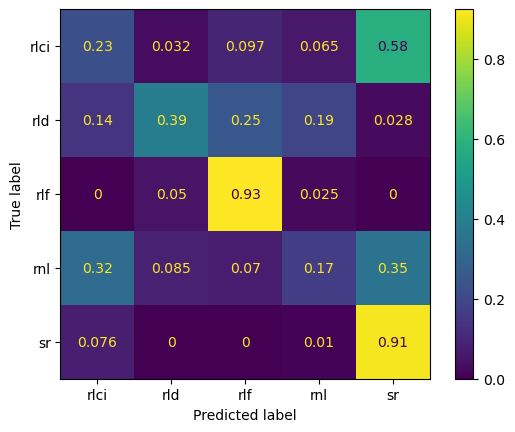

In [7]:
from sklearn.metrics import classification_report, plot_confusion_matrix, ConfusionMatrixDisplay
print(dataset.classes)
print(classification_report(y_pred=y_pred, y_true=y_true))
conf = confusion_matrix(y_pred=y_pred, y_true=y_true)
disp = ConfusionMatrixDisplay(conf/conf.astype(float).sum(axis=1)[:, np.newaxis], display_labels=dataset.classes)

disp.plot()

In [9]:
features = {}
def get_features(name):
    def hook(model, input, output):
        features[name] = output.detach()
    return hook

In [10]:
print(model[1].register_forward_hook(get_features("feats")))

In [11]:
for batch in tqdm(train_loader, desc=f"Epoch {epoch + 1} in training", leave=False):
    x, y = batch
    x, y = x[2].to(device), y[2].to(device)
    y_hat = model(x.unsqueeze(0))
    print(dataset.classes[y])
    break;

rlci


In [12]:
x.shape

torch.Size([3, 299, 299])

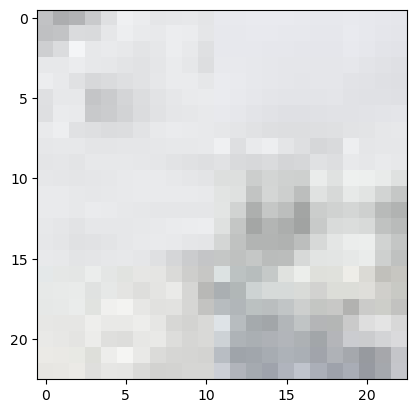

In [13]:
xx,yy = 3, 0
plt.imshow(torch.permute(x.detach().cpu(), (1,2,0))[PATCH_WIDTH*yy:PATCH_WIDTH*(yy+1), PATCH_WIDTH*xx:PATCH_HEIGHT*(xx+1),:], interpolation=None)

In [15]:
imgs = features['feats'].view((1, 13, 13, 24, 11,11))

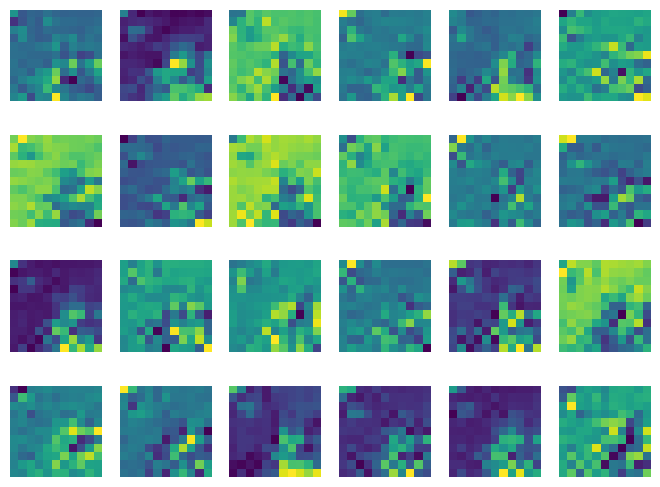

In [16]:
gridSpec = dict(top = 1, bottom = 0, right = 1, left = 0, hspace = 0.2, wspace = 0.2)

fig, axes = plt.subplots(4, 6, sharex=True, sharey=True, gridspec_kw=gridSpec)
for i in range((4)):
    for j in range((6)):
        axes[i,j].axis('off')
        axes[i,j].set_aspect('equal')
        axes[i,j].imshow(imgs[0, yy, xx, i*6+j].detach().cpu(), interpolation=None)

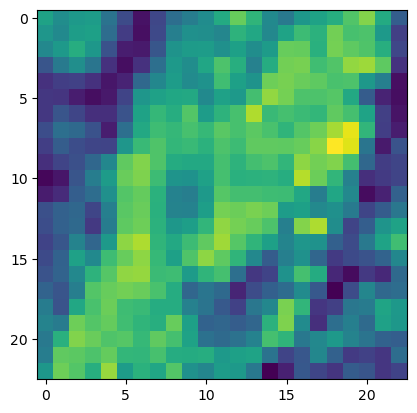

In [ ]:
plt.imshow(torch.permute(x.detach().cpu(), (1,2,0))[PATCH_WIDTH*yy:PATCH_WIDTH*(yy+1), PATCH_WIDTH*xx:PATCH_HEIGHT*(xx+1),0], interpolation=None)
